## Train data import and processing

In [ ]:
import os, gc
import datetime

import numpy as np
import pandas as pd

import category_encoders

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder


from lightgbm import LGBMRegressor


from xgboost import XGBRegressor
import pickle
import joblib
from tqdm import tqdm
import lightgbm as lgb

from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime

In [ ]:
# Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16
def reduce_mem_usage(data, use_float16=False) -> pd.DataFrame:
    start_mem = data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in data.columns:
        if is_datetime(data[col]) or is_categorical_dtype(data[col]):
            continue
        col_type = data[col].dtype

        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)
        else:
            data[col] = data[col].astype('category')

    end_mem = data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.2f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return data

In [ ]:
# Path to data 
PATH = '../input/ashrae-energy-prediction/'

In [ ]:
# Import train data
train = pd.read_csv(f'{PATH}train.csv')
weather_train = pd.read_csv(f'{PATH}weather_train.csv')

# Import metadata
metadata = pd.read_csv(f'{PATH}building_metadata.csv')

In [ ]:
# Remove outliers in train data
train = train[train['building_id'] != 1099]
train = train.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

In [ ]:
# Function for weather data processing
def weather_data_parser(weather_data) -> pd.DataFrame:
    time_format = '%Y-%m-%d %H:%M:%S'
    start_date = datetime.datetime.strptime(weather_data['timestamp'].min(), time_format)
    end_date = datetime.datetime.strptime(weather_data['timestamp'].max(), time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    for site_id in range(16):
        site_hours = np.array(weather_data[weather_data['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list, site_hours), columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_data = pd.concat([weather_data, new_rows], sort=True)
        weather_data = weather_data.reset_index(drop=True)           

    weather_data['datetime'] = pd.to_datetime(weather_data['timestamp'])
    weather_data['day'] = weather_data['datetime'].dt.day
    weather_data['week'] = weather_data['datetime'].dt.week
    weather_data['month'] = weather_data['datetime'].dt.month

    weather_data = weather_data.set_index(['site_id', 'day', 'month'])

    air_temperature_filler = pd.DataFrame(weather_data.groupby(['site_id','day','month'])['air_temperature'].median(), columns=['air_temperature'])
    weather_data.update(air_temperature_filler, overwrite=False)

    cloud_coverage_filler = weather_data.groupby(['site_id', 'day', 'month'])['cloud_coverage'].median()
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'), columns=['cloud_coverage'])

    weather_data.update(cloud_coverage_filler, overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_data.groupby(['site_id','day','month'])['dew_temperature'].median(), columns=['dew_temperature'])
    weather_data.update(due_temperature_filler, overwrite=False)

    sea_level_filler = weather_data.groupby(['site_id','day','month'])['sea_level_pressure'].median()
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'), columns=['sea_level_pressure'])

    weather_data.update(sea_level_filler, overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_data.groupby(['site_id','day','month'])['wind_direction'].median(), columns=['wind_direction'])
    weather_data.update(wind_direction_filler, overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_data.groupby(['site_id','day','month'])['wind_speed'].median(), columns=['wind_speed'])
    weather_data.update(wind_speed_filler, overwrite=False)

    precip_depth_filler = weather_data.groupby(['site_id','day','month'])['precip_depth_1_hr'].median()
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'), columns=['precip_depth_1_hr'])

    weather_data.update(precip_depth_filler, overwrite=False)

    weather_data = weather_data.reset_index()
    weather_data = weather_data.drop(['datetime','day','week','month'], axis=1)

    return weather_data

In [ ]:
# Train weather data processing
weather_train = weather_data_parser(weather_train)

In [ ]:
# Memory optimization
train = reduce_mem_usage(train, use_float16=True)
weather_train = reduce_mem_usage(weather_train, use_float16=True)
metadata = reduce_mem_usage(metadata, use_float16=True)

Memory usage of dataframe is 757.31 MB
Memory usage after optimization is: 322.24 MB
Decreased by 57.45%
Memory usage of dataframe is 9.65 MB
Memory usage after optimization is: 2.66 MB
Decreased by 72.46%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.76%


In [ ]:
# Merge train data 
train = train.merge(metadata, on='building_id', how='left')
train = train.merge(weather_train, on=['site_id', 'timestamp'], how='left')

del weather_train; gc.collect()

0

In [ ]:
# Function for train and test data processing
def data_parser(data) -> pd.DataFrame:
    data.sort_values('timestamp')
    data.reset_index(drop=True)
    
    data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')
    data['weekday'] = data['timestamp'].dt.weekday
    data['hour'] = data['timestamp'].dt.hour
    
    data['square_feet'] =  np.log1p(data['square_feet']) 
    
    data = data.drop(['timestamp', 'sea_level_pressure',
        'wind_direction', 'wind_speed', 'year_built', 'floor_count'], axis=1)
    
    gc.collect()
    
    encoder = LabelEncoder()
    data['primary_use'] = encoder.fit_transform(data['primary_use'])
    
    return data


In [ ]:
# Train data processing
train = data_parser(train)

In [ ]:
train["meter_reading"] = np.log1p(train['meter_reading'])

In [ ]:
from sklearn.model_selection import train_test_split
train_x, cv_x= train_test_split(train, test_size=0.20, shuffle=False)

In [ ]:
y_cv=cv_x['meter_reading']

In [ ]:
cv_x.drop("meter_reading", axis=1, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test= train_test_split(train_x, test_size=0.50, shuffle=False)

In [ ]:
y_test= X_test['meter_reading']
X_test.drop("meter_reading", axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
target = train["meter_reading"]
train = train.drop("meter_reading", axis=1)

In [ ]:
train.columns

In [ ]:
# Process categorical features
categorical_features = ['building_id', 'site_id', 'meter', 'primary_use']

encoder = category_encoders.CountEncoder(cols=categorical_features)
encoder.fit(train)
train = encoder.transform(train)

features_size = train.shape[0]
for feature in categorical_features:
    train[feature] = train[feature] / features_size

In [ ]:
# Missing data imputation
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(train)
train = imputer.transform(train)

Custom stacked Models

In [ ]:
def create_10_models(df):
 """
 train 10 models with 10 different samples
 """
 models_list = []
 for i in tqdm(range(10)):
   #Sample rows from D1
    df_tr=df.sample(n=3500000, replace=True) 
    y_tr= df_tr['meter_reading']
    df_tr.drop('meter_reading', axis=1, inplace=True)

    #train GBDT on D1
    gb_trees = lgb.LGBMRegressor(n_estimators=500,objective='regression', n_jobs=-1)
    models_list.append(gb_trees.fit(df_tr,y_tr))

 return models_list


In [ ]:
model_list= create_10_models(X_train)

100%|██████████| 10/10 [08:48<00:00, 52.85s/it]


In [ ]:
#Predict on D2 using above models
def predict_base_models(models,data):
  y_pred=[]
  for i in tqdm(models):
    y_hat=i.predict(data)
    y_pred.append(y_hat)
  
  return y_pred

In [ ]:
y_pred=predict_base_models(model_list,X_test)

100%|██████████| 10/10 [10:36<00:00, 63.68s/it]


In [ ]:
#create dataset with the above predictions
def create_dataset(predict_values):
  pred_values=np.reshape(predict_values[0], (len(predict_values[0]),1))
  for i in range(1,len(predict_values)):
    pred= np.reshape(predict_values[i], (len(predict_values[i]),1))
    pred_values= np.hstack((pred_values,pred))
  
  return pred_values

In [ ]:
import math
pred_dataset=create_dataset(y_pred)
lgb_model=lgb.LGBMRegressor(boosting_type='gbdt', n_estimators=500, objective='regression',n_jobs=-1)
lgb_model.fit(pred_dataset,y_test)
cv_pred= predict_base_models(model_list,cv_x)
pred_data_cv=create_dataset(cv_pred)
pred_stack_cv=lgb_model.predict(pred_data_cv)
print("CV rmse for stacking regressor with estimators:",500,'is',math.sqrt(mean_squared_error(y_cv, pred_stack_cv)))

100%|██████████| 10/10 [05:09<00:00, 30.97s/it]


CV rmse for stacking regressor with estimators: 500 is 1.1201837266051247


In [ ]:
import pickle
import joblib
filename_reg='lgb_model.sav'
joblib.dump(lgb_model,filename_reg)

['lgb_model.sav']

## Test data import and processing

In [ ]:
# Import test data
test = pd.read_csv(f'{PATH}test.csv')
weather_test = pd.read_csv(f'{PATH}weather_test.csv')

In [ ]:
row_ids = test['row_id']
test.drop('row_id', axis=1, inplace=True)

In [ ]:
# Test weather data processing
weather_test = weather_data_parser(weather_test)

In [ ]:
# Memory optimization
test = reduce_mem_usage(test, use_float16=True)
weather_test = reduce_mem_usage(weather_test, use_float16=True)

Memory usage of dataframe is 954.38 MB
Memory usage after optimization is: 199.59 MB
Decreased by 79.09%
Memory usage of dataframe is 19.25 MB
Memory usage after optimization is: 5.30 MB
Decreased by 72.45%


In [ ]:

# Merge test data
test = test.merge(metadata, on='building_id', how='left')
test = test.merge(weather_test, on=['site_id', 'timestamp'], how='left')

del metadata; gc.collect()

0

In [ ]:
# Test data processing
test = data_parser(test)




In [ ]:
test = encoder.transform(test)
for feature in categorical_features:
    test[feature] = test[feature] / features_size

In [ ]:

test = imputer.transform(test)

## Make predictions and create submission file

In [ ]:
y_pred = lgb_model.predict(test)

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/ashrae-energy-prediction/sample_submission.csv")
sample_submission["meter_reading"] =  np.expm1(y_pred)
sample_submission.to_csv("./custom_stacked_submission.csv", index=False)

In [1]:
from prettytable import PrettyTable
summary = PrettyTable()


summary.field_names = ["Model","RMSE"]
summary.add_row(["Custom_Stacked_Regression",1.12])

print(summary)

+---------------------------+------+
|           Model           | RMSE |
+---------------------------+------+
| Custom_Stacked_Regression | 1.12 |
+---------------------------+------+


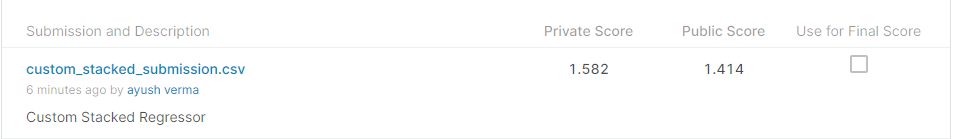

In [3]:
from IPython.display import Image
Image(filename='/content/custom_stacked_regressor.PNG')

Summary
1. I impute weather data with mean and median
2. I imput the the remaining missing values with SimpleImputer with median
3. Very basic FE because of the ram problem and also i seen in the lightgb gbdt that raw features are the most important fetaures 
4. Remove outlier
5. Do standardisation on train and test
6. Build the custom stacked regressor models with sampling with replacement
7. This file run on kaggle notebook please don't try to run on the google colab because of the limited ram


Refrences

1. https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling